In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import gmplot
import gmaps
from sklearn.cluster import DBSCAN
from sklearn import metrics
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
import os


%matplotlib inline

In [2]:
UserId = '001'
UserData = './Downloads/Geolife Trajectories 1.3/Geolife Trajectories 1.3/Data/' + UserId + '/Trajectory/'



FileList = os.listdir(UserData) 
Names = ['Lat', 'Long', 'Zero', 'Alt', 'Days', 'Date', 'Time']
DF_List = [pd.read_csv(UserData + TheFile, header=6, names=Names, index_col=False) for TheFile in FileList]
GPS_Data = pd.concat(DF_List, ignore_index=True)

# delete unused column
GPS_Data.drop(['Zero', 'Days'], axis=1, inplace=True)

# data is recorded every 1~5 seconds, which is too frequent. Reduce it to every minute
GPS_Data = GPS_Data.iloc[::12, :]

In [3]:
GPS_Data.head(10)

,Lat,Long,Alt,Date,Time
0,39.984198,116.319322,492,2008-10-23,05:53:06
12,39.984611,116.319822,304,2008-10-23,05:53:58
24,39.984252,116.320826,227,2008-10-23,05:54:43
36,39.983916,116.320980,180,2008-10-23,05:55:39
48,39.982688,116.321225,154,2008-10-23,05:56:17
60,39.981441,116.321305,97,2008-10-23,05:56:55
72,39.980291,116.321430,81,2008-10-23,05:57:32
84,39.979675,116.321805,100,2008-10-23,05:58:18
96,39.979546,116.322926,115,2008-10-23,05:59:11
108,39.979758,116.324513,98,2008-10-23,05:59:47


In [4]:
gmap = gmplot.GoogleMapPlotter(GPS_Data.Lat[0], GPS_Data.Long[0], 11)
gmap.plot(GPS_Data.Lat, GPS_Data.Long)
gmap.draw(r'./Desktop/GPS_Traces.html')

In [18]:
Coords = GPS_Data.as_matrix(columns=['Lat', 'Long'])
KM_Per_Radian = 6371.0088
Epsilon = 0.5 / KM_Per_Radian


ClusterData = DBSCAN(eps=Epsilon, min_samples=100, algorithm='ball_tree', metric='haversine').fit(np.radians(Coords))
ClusterLabels = ClusterData.labels_

ClusterNumber = len(set(ClusterLabels) - set([-1]))
Clusters = pd.Series([Coords[ClusterLabels == n] for n in range(ClusterNumber)])
Clusters

0    [[39.984198, 116.319322], [39.984611, 116.3198...
1    [[40.069857, 116.333592], [40.069868, 116.3351...
2    [[39.909038, 116.411921], [39.908906, 116.4114...
3    [[39.967153, 116.431587], [39.966697, 116.4324...
dtype: object

In [19]:
def GetCentermostPoint(Cluster):
    
    Centroid = (MultiPoint(Cluster).centroid.x, MultiPoint(Cluster).centroid.y)
    CentermostPoint = min(Cluster, key=lambda point: great_circle(point, Centroid).m)
    
    return tuple(CentermostPoint)

# get the centroid point for each cluster
CentermostPoints = Clusters.map(GetCentermostPoint)
Lat, Long = zip(*CentermostPoints)
RepPoints = pd.DataFrame({'Lat' : Lat, 'Long' : Long})

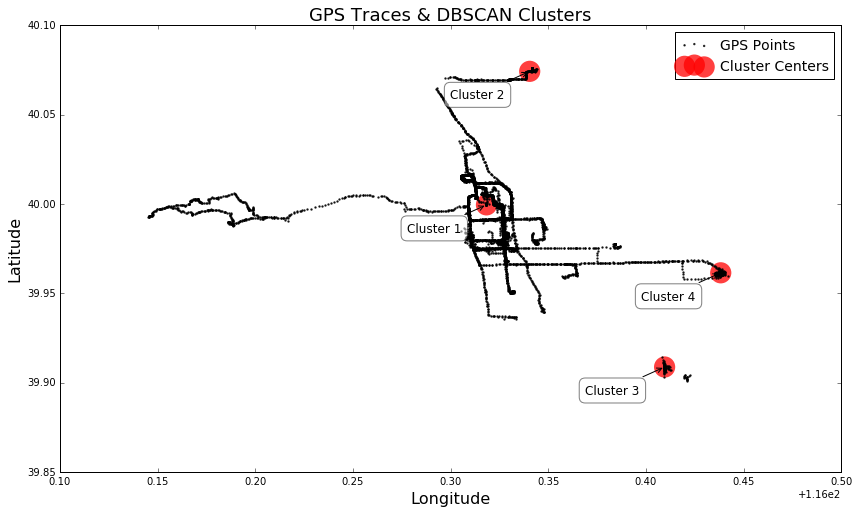

In [23]:
fig, ax = plt.subplots(figsize=[14, 8])

rs_scatter = ax.scatter(RepPoints['Long'][0], RepPoints['Lat'][0], c='r', edgecolor='None', alpha=0.75, s=450)
ax.scatter(RepPoints['Long'][1], RepPoints['Lat'][1], c='r', edgecolor='None', alpha=0.75, s=450)
ax.scatter(RepPoints['Long'][2], RepPoints['Lat'][2], c='r', edgecolor='None', alpha=0.75, s=450)
ax.scatter(RepPoints['Long'][3], RepPoints['Lat'][3], c='r', edgecolor='None', alpha=0.75, s=450)

df_scatter = ax.scatter(GPS_Data.Long, GPS_Data.Lat, c='k', edgecolors='k', alpha=0.75, s=2)
ax.set_title('GPS Traces & DBSCAN Clusters', fontsize=18)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.legend([df_scatter, rs_scatter], ['GPS Points', 'Cluster Centers'], loc='upper right', fontsize=14)


Labels = ['Cluster {0}'.format(i) for i in range(1, ClusterNumber+1)]

for label, x, y in zip(Labels, RepPoints['Long'], RepPoints['Lat']):
    
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-25, -30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'),
        fontsize=12)

plt.show()

In [8]:
GPS_Data.head()

,Lat,Long,Alt,Date,Time
0,39.984198,116.319322,492,2008-10-23,05:53:06
12,39.984611,116.319822,304,2008-10-23,05:53:58
24,39.984252,116.320826,227,2008-10-23,05:54:43
36,39.983916,116.320980,180,2008-10-23,05:55:39
48,39.982688,116.321225,154,2008-10-23,05:56:17


In [9]:
M = []

def myfunc(row):    
    t = GPS_Data[(GPS_Data['Lat']==row[0]) & (GPS_Data['Long']==row[1])]['Time'].iloc[0]
    
    return t[:t.index(':')]


for i in range(ClusterNumber):
    
    hours = np.apply_along_axis(myfunc, 1, Clusters[i]).tolist()
    M.append(map(int, hours))
    
A = [list(SubM) for SubM in M]

([<matplotlib.axis.XTick at 0x22f558fd518>,
 <a list of 13 Text xticklabel objects>)

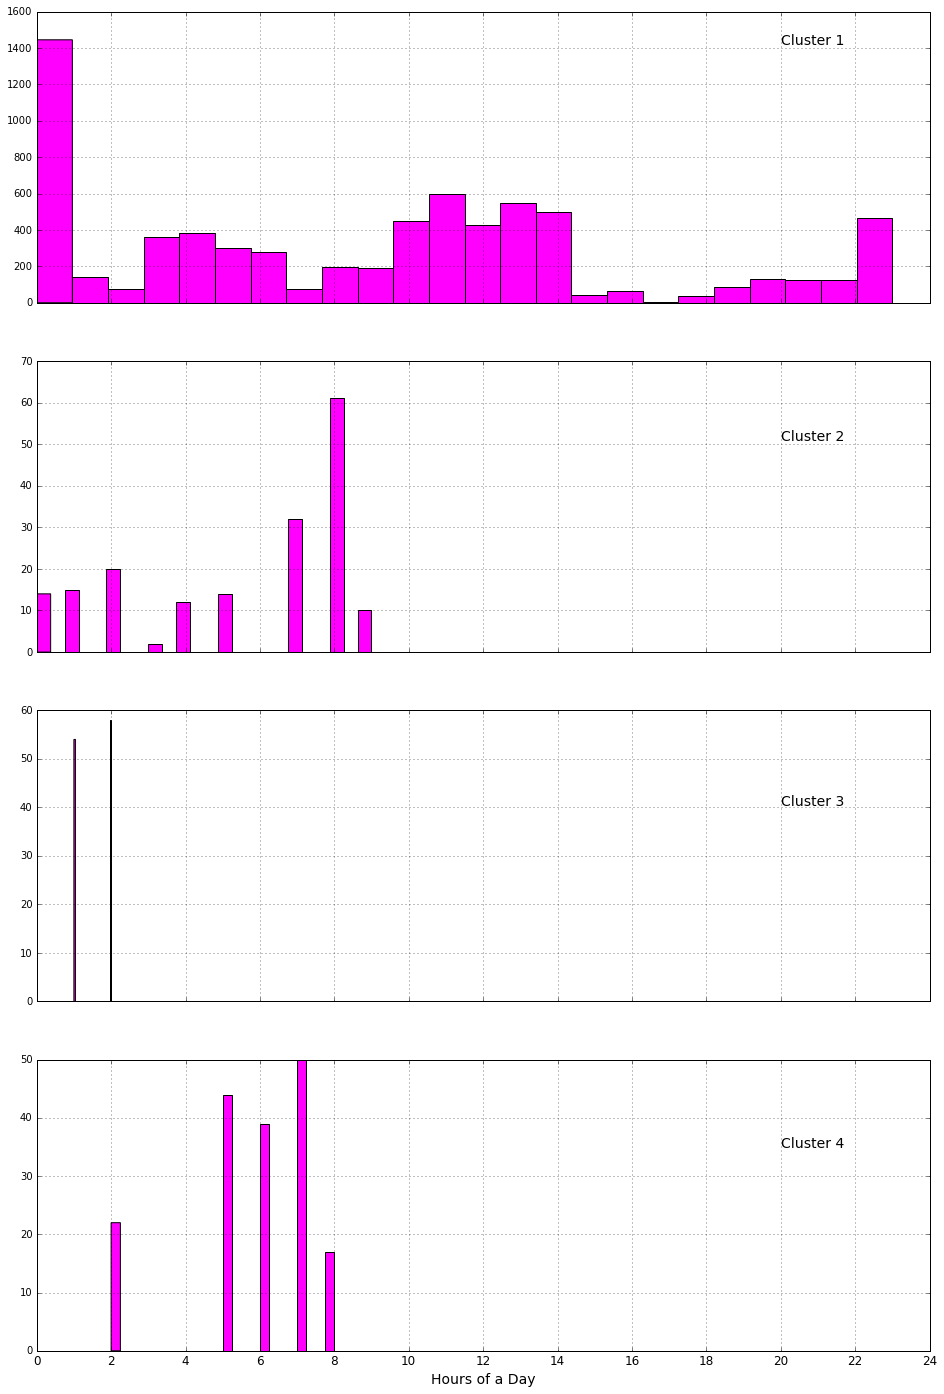

In [10]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(16,24))

ax1.hist(A[0], bins=24, color='magenta')
ax1.text(20, 1420, 'Cluster 1', fontsize=14)
ax1.grid()

ax2.hist(A[1], bins=24, color='magenta')
ax2.text(20, 51, 'Cluster 2', fontsize=14)
ax2.grid()

ax3.hist(A[2], bins=24, color='magenta')
ax3.text(20, 40.5, 'Cluster 3', fontsize=14)
ax3.grid()

ax4.hist(A[3], bins=24, color='magenta')
ax4.text(20, 35, 'Cluster 4', fontsize=14)
ax4.grid()

ax4.set_xlabel('Hours of a Day', fontsize=14)
plt.xlim([0, 24])
plt.xticks(np.arange(0, 24.01, 2.0), fontsize=12)

In [11]:
gmap = gmplot.GoogleMapPlotter(RepPoints['Lat'][0], RepPoints['Long'][0], 11)
gmap.plot(GPS_Data.Lat, GPS_Data.Long)
gmap.heatmap(RepPoints['Lat'][:3], RepPoints['Long'][:3], radius=30)
gmap.draw(r'./Desktop/Traces&Clusters.html')